This notebook validates reproducibility, limiting cases, and the order parameter.

In [48]:
import numpy as np
from src.universe_sim import run_simulation

h1 = run_simulation(N=50, steps=200, seed=42, save_every=10)
h2 = run_simulation(N=50, steps=200, seed=42, save_every=10)

print("same shape:", h1.shape == h2.shape)
print("allclose:", np.allclose(h1, h2))
print("max abs diff:", np.max(np.abs(h1 - h2)))

same shape: True
allclose: True
max abs diff: 0.0


All simulations are initialized with a fixed random seed for reproducibility.
For parameter sweeps, multiple seeds are used and results are averaged.

In [49]:
import sys
from pathlib import Path

# Add project root (containing "src/") to Python path
here = Path.cwd().resolve()
candidates = [here] + list(here.parents)

project_root = None
for p in candidates:
    if (p / "src").exists():
        project_root = p
        break

if project_root is None:
    raise RuntimeError(f"Cannot find project root from cwd={here}. Open VSCode at repo root.")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Using project root:", project_root)
print("Python:", sys.executable)

Using project root: /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe
Python: /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/.venv/bin/python


In [50]:
import numpy as np
import matplotlib.pyplot as plt

from src.universe_sim import run_simulation
from src.metrics import largest_cluster_fraction, density_variance_grid, nearest_neighbor_distance

In [51]:
BASE = dict(N=200, steps=800, seed=0, save_every=20, box_size=1.0, dt=1.0)

FIXED = dict(attraction=0.02, repulsion_radius=0.05)

def sim(**overrides):
    return run_simulation(**BASE, **FIXED, **overrides)


Parameter effectiveness (one parameter at a time)
We vary one parameter while keeping all others fixed (including the random seed) to confirm each parameter has the expected qualitative effect.

In [52]:
hn_low = sim(noise=0.005)
hn_hi  = sim(noise=0.05)

print("LCF noise low:", largest_cluster_fraction(hn_low[-1], eps=0.06, box_size=1.0))
print("LCF noise high:", largest_cluster_fraction(hn_hi[-1], eps=0.06, box_size=1.0))

LCF noise low: 1.0
LCF noise high: 0.09


In [53]:
h_r1 = sim(interaction_range=0.3, noise=0.01)
h_r2 = sim(interaction_range=0.8, noise=0.01)

print("LCF range=0.3:", largest_cluster_fraction(h_r1[-1], eps=0.06, box_size=1.0))
print("LCF range=0.8:", largest_cluster_fraction(h_r2[-1], eps=0.06, box_size=1.0))

LCF range=0.3: 1.0
LCF range=0.8: 0.995


Limiting cases
We test three regimes:
A) No attraction → no systematic clustering
B) Very high noise → destroys structure
C) Strong attraction + low noise → robust clustering


In [54]:
# Case A: attraction = 0
h_noatt = run_simulation(N=300, steps=1500, seed=1, attraction=0.0, noise=0.01,
                         interaction_range=0.6, repulsion_radius=0.05, save_every=30)
posA = h_noatt[-1]

# Case B: very high noise
h_highN = run_simulation(N=300, steps=1500, seed=1, attraction=0.03, noise=0.08,
                         interaction_range=0.6, repulsion_radius=0.05, save_every=30)
posB = h_highN[-1]

# Case C: strong attraction + low noise
h_cluster = run_simulation(N=300, steps=1500, seed=1, attraction=0.05, noise=0.005,
                           interaction_range=0.6, repulsion_radius=0.05, save_every=30)
posC = h_cluster[-1]

for name, pos in [("A", posA), ("B", posB), ("C", posC)]:
    print(name,
          "LCF=", largest_cluster_fraction(pos, eps=0.06, box_size=1.0))

A LCF= 0.42
B LCF= 0.17333333333333334
C LCF= 1.0


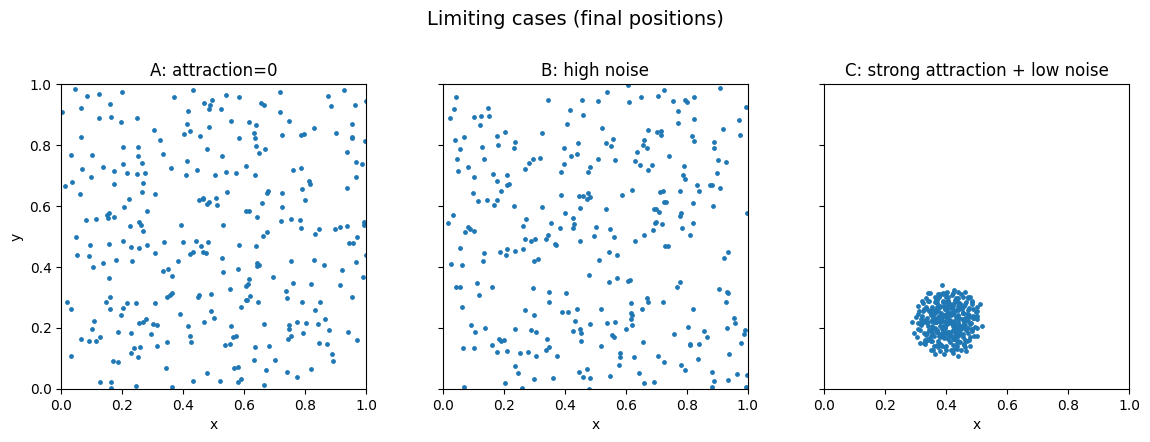

In [55]:
def plot_limiting_panels(posA, posB, posC, titles):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
    for ax, pos, title in zip(axes, [posA, posB, posC], titles):
        ax.scatter(pos[:, 0], pos[:, 1], s=6)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_aspect("equal")
        ax.set_title(title)
        ax.set_xlabel("x")
    axes[0].set_ylabel("y")
    fig.suptitle("Limiting cases (final positions)", y=1.05, fontsize=14)
    fig.tight_layout()
    plt.show()

plot_limiting_panels(
    posA, posB, posC,
    titles=[
        "A: attraction=0",
        "B: high noise",
        "C: strong attraction + low noise",
    ],
)

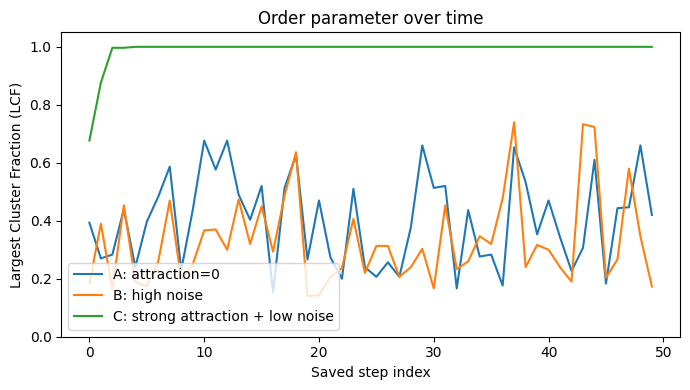

In [56]:
def lcf_timeseries(history, eps=0.06, box_size=1.0):
    return np.array([largest_cluster_fraction(frame, eps=eps, box_size=box_size) for frame in history])

def plot_lcf_over_time(hA, hB, hC, labels, eps=0.06, box_size=1.0):
    lA = lcf_timeseries(hA, eps=eps, box_size=box_size)
    lB = lcf_timeseries(hB, eps=eps, box_size=box_size)
    lC = lcf_timeseries(hC, eps=eps, box_size=box_size)

    plt.figure(figsize=(7, 4))
    plt.plot(lA, label=labels[0])
    plt.plot(lB, label=labels[1])
    plt.plot(lC, label=labels[2])
    plt.ylim(0, 1.05)
    plt.xlabel("Saved step index")
    plt.ylabel("Largest Cluster Fraction (LCF)")
    plt.title("Order parameter over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_lcf_over_time(
    h_noatt, h_highN, h_cluster,
    labels=["A: attraction=0", "B: high noise", "C: strong attraction + low noise"],
    eps=0.06,
    box_size=1.0,
)

The results show that:
- Without attraction, the system remains disordered.
- High noise prevents stable structure formation.
- Strong attraction combined with low noise leads to a rapid transition to a clustered state.

This confirms that the model behaves consistently in physically meaningful limiting regimes.